## 目录
1. 因子参数优化
2. 事件参数优化
3. 拓展：外部自定义带参算法优化

In [37]:
from jaqs_fxdayu.data import DataView 
import warnings

warnings.filterwarnings("ignore")
dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [13]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == 0
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False, add_data=True)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False, add_data=True)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

In [14]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()

In [15]:
from jaqs_fxdayu.research import Optimizer

## 1. 因子参数优化

In [16]:
price = dv.get_ts('close_adj')
high = dv.get_ts('high_adj')
low = dv.get_ts('low_adj')
price_bench = dv.data_benchmark
optimizer = Optimizer(dataview=dv,
                      formula='- Correlation(vwap_adj, volume, LEN)',
                      params={"LEN":range(2,15,1)},
                      name='divert',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=30,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

### 优化目标
### target_type:
* ic类:
  return_ic/upside_ret_ic/downside_ret_ic
* 持有收益类
  long_ret/short_ret/long_short_ret/top_quantile_ret/bottom_quantile_ret/tmb_ret
* 收益空间类
  long_space/short_space/long_short_space/top_quantile_space/bottom_quantile_space/tmb_space

### target:
* ic类 
  "IC Mean", "IC Std.", "t-stat(IC)", "p-value(IC)", "IC Skew", "IC Kurtosis", "Ann. IR"
* 持有收益类 
  't-stat', "p-value", "skewness", "kurtosis", "Ann. Ret", "Ann. Vol", "Ann. IR", "occurance"
* 收益空间类 
  'Up_sp Mean','Up_sp Std','Up_sp IR','Up_sp Pct5', 'Up_sp Pct25 ','Up_sp Pct50 ', 'Up_sp Pct75','Up_sp Pct95','Up_sp Occur','Down_sp Mean','Down_sp Std', 'Down_sp IR', 'Down_sp Pct5','Down_sp Pct25 ','Down_sp Pct50 ','Down_sp Pct75', 'Down_sp Pct95','Down_sp Occur'

In [18]:
ret_best = optimizer.enumerate_optimizer(target_type="top_quantile_ret",#优化目标类型 
                                         target="Ann. IR",#优化目标     
                                         in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                         ascending=False)#是否按优化目标升序排列(从小到大)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


In [19]:
# 样本内最优绩效
print(ret_best[0]["signal_name"])
print(ret_best[0]["ret"])
print(ret_best[0]["ic"])
print(ret_best[0]["space"])

divert{'LEN': 12}
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       5.124623   -4.671154        3.002314         33.406886   
p-value      0.000000    0.000000        0.002820          0.000000   
skewness    -0.574749    0.308295       -1.134718          0.672716   
kurtosis    -0.020546   -0.321323        4.024431          3.701657   
Ann. Ret     0.263163   -0.254330        0.026169          0.309079   
Ann. Vol     0.399007    0.423049        0.067725          0.534581   
Ann. IR      0.659545   -0.601183        0.386401          0.578172   
occurance  488.000000  488.000000      488.000000      26932.000000   

           bottom_quantile_ret     tmb_ret  all_sample_ret  
t-stat               23.920794    4.053846       68.895067  
p-value               0.000000    0.000060        0.000000  
skewness              0.734033   -0.947489        0.952250  
kurtosis              2.511366    3.154532        4.297959  
Ann. Ret              0.232214    0.0

In [20]:
from jaqs_fxdayu.research import SignalDigger
from jaqs_fxdayu.research.signaldigger.analysis import analysis

import matplotlib.pyplot as plt
obj = SignalDigger()

def draw_analysis(signal_data,period):  
    obj.signal_data = signal_data
    obj.period = period
    obj.create_full_report()
    plt.show()

#### 全样本可视化



Value of signals of Different Quantiles Statistics
                min       max      mean       std  count    count %
quantile                                                           
1        -18.335262 -0.054921 -0.789213  0.133347  55208  20.142803
2         -0.909730  0.444112 -0.602800  0.151864  54825  20.003065
3         -0.852591  0.664250 -0.435393  0.195649  54792  19.991025
4         -0.773218  0.804137 -0.232928  0.229822  54825  20.003065
5         -0.644345  0.987584  0.151546  0.290481  54433  19.860042
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.068
IC Std.       0.139
t-stat(IC)   15.161
p-value(IC)   0.000
IC Skew       0.001
IC Kurtosis   0.123
Ann. IR       0.493
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


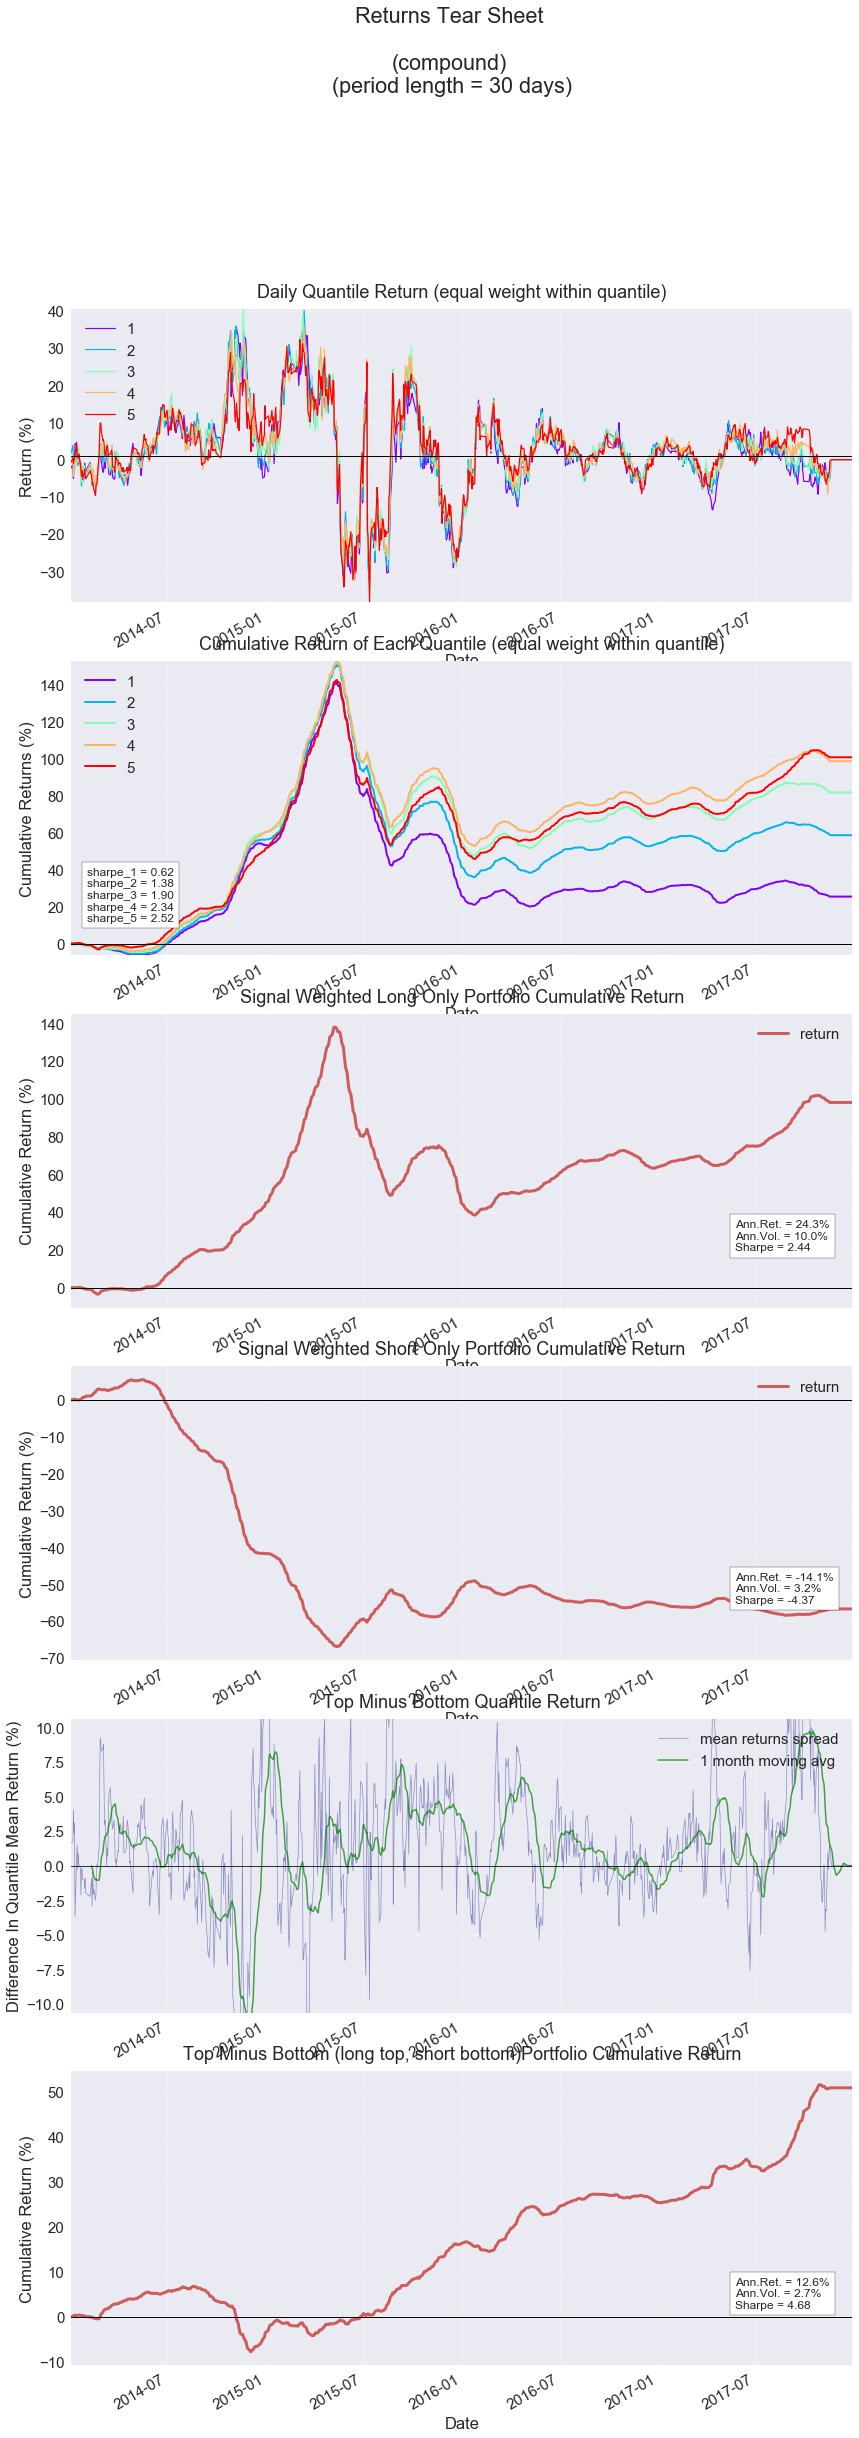

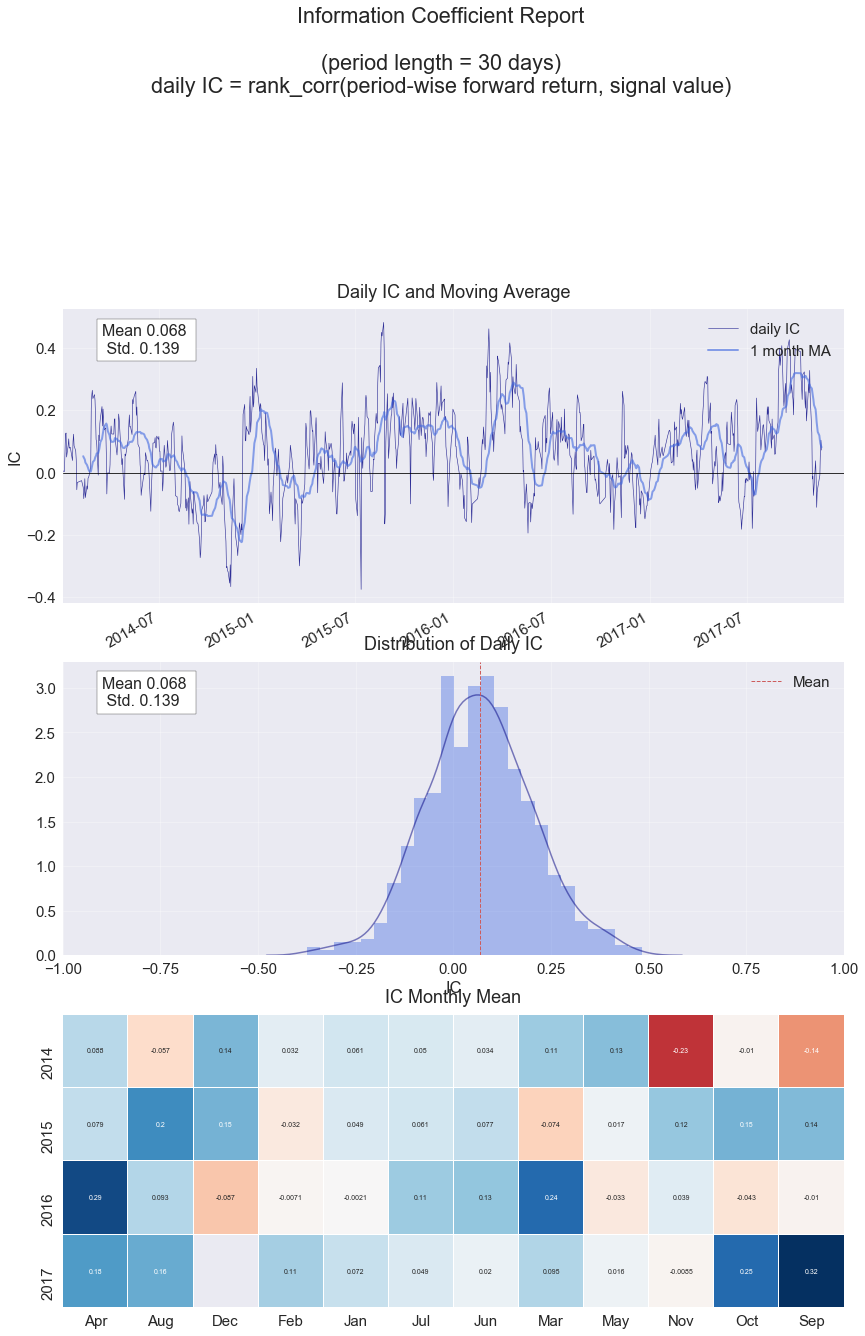

In [21]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]], period=30)

#### 样本内可视化



Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1        -1.523660 -0.054921 -0.802340  0.108187  27326  20.147163
2        -0.909730  0.444112 -0.629085  0.159196  27129  20.001917
3        -0.852591  0.664250 -0.468080  0.211268  27116  19.992332
4        -0.773218  0.804137 -0.269078  0.249988  27129  20.001917
5        -0.644345  0.964528  0.119799  0.308186  26932  19.856671
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                ic
IC Mean      0.050
IC Std.      0.138
t-stat(IC)   7.994
p-value(IC)  0.000
IC Skew     -0.279
IC Kurtosis  0.359
Ann. IR      0.362
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


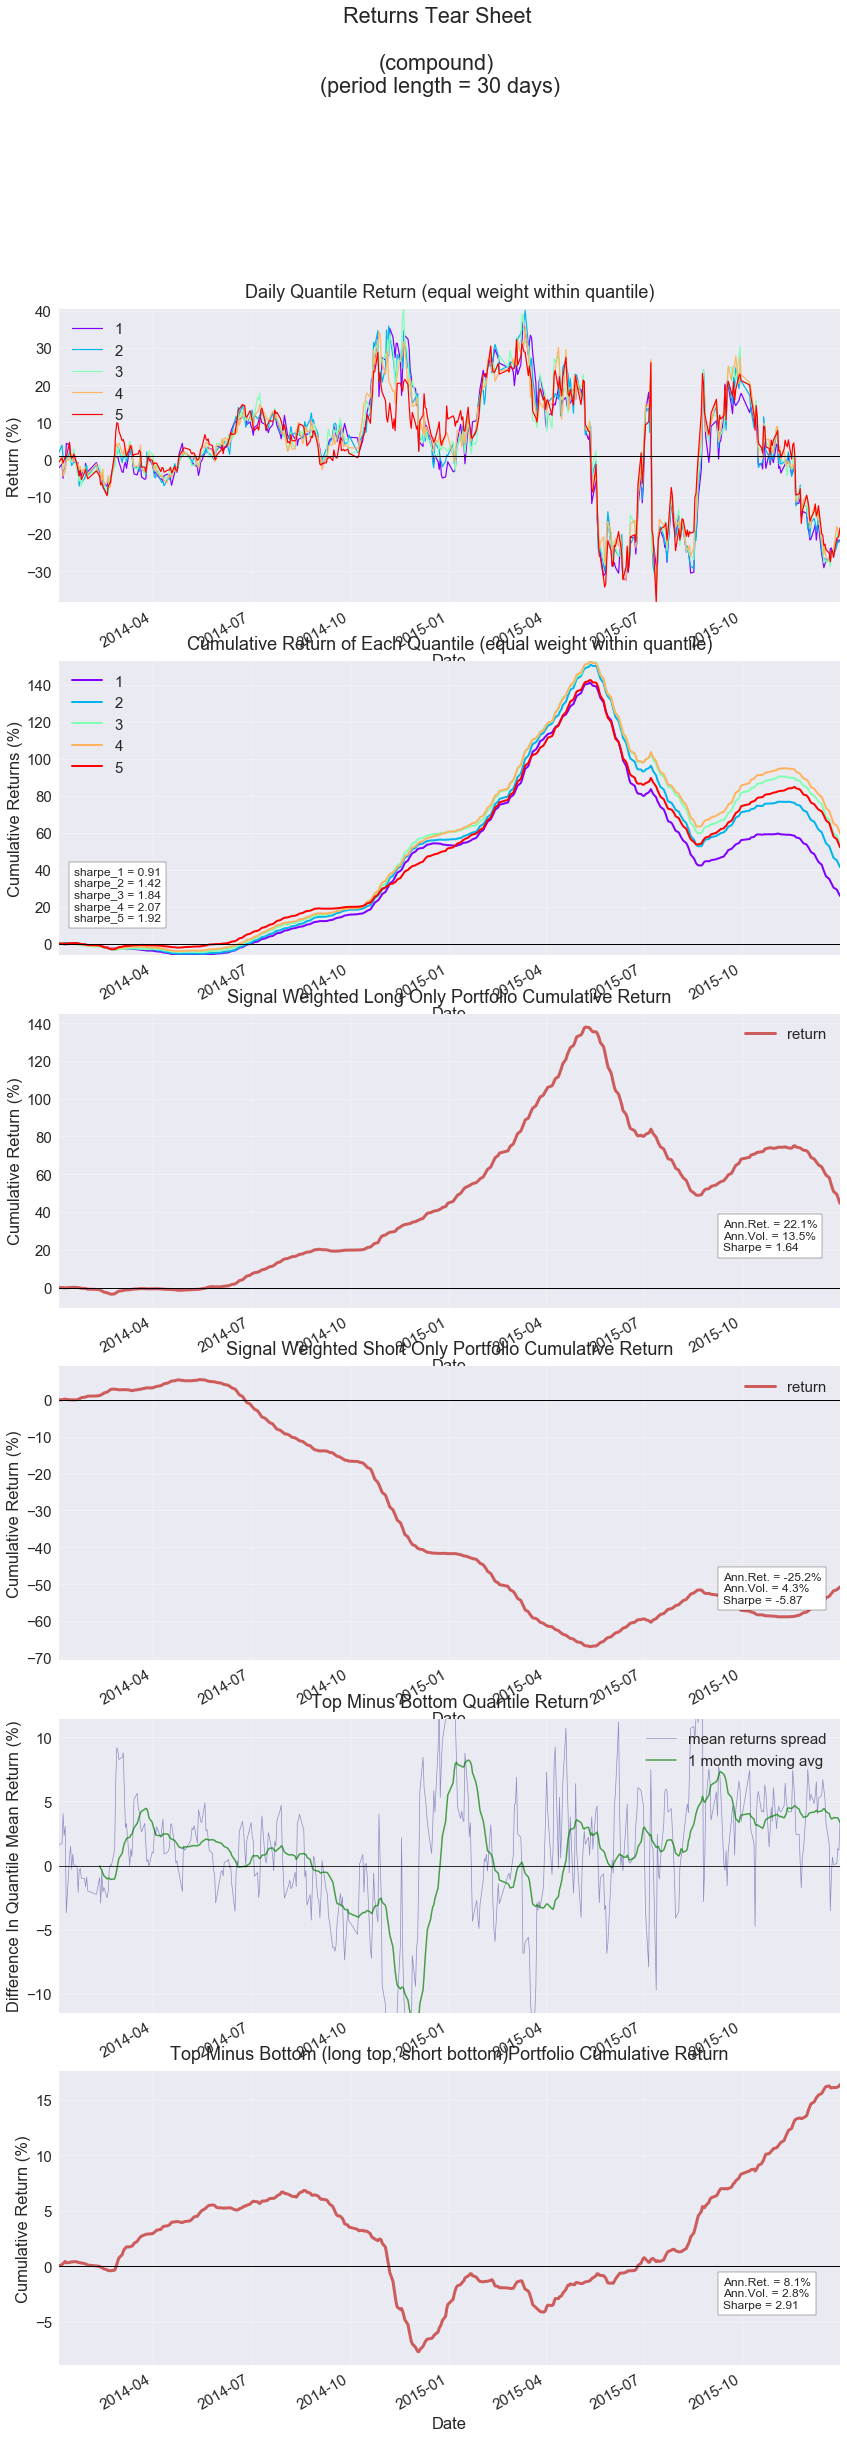

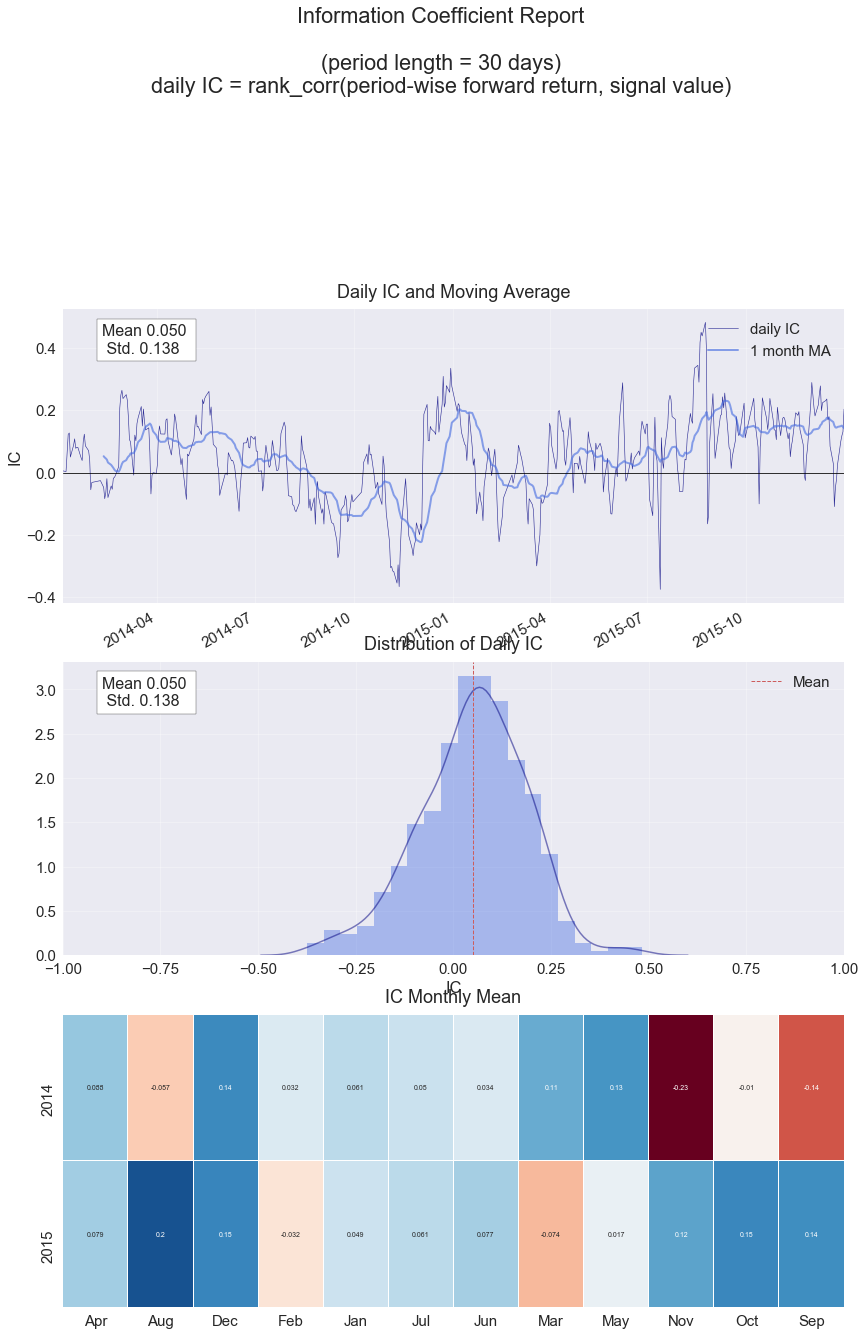

In [22]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20140101:20160101], period=30)

#### 样本外可视化



Value of signals of Different Quantiles Statistics
                min       max      mean       std  count    count %
quantile                                                           
1        -18.335262 -0.240928 -0.776347  0.152981  27882  20.138533
2         -0.908570  0.088163 -0.577054  0.139606  27696  20.004189
3         -0.826511  0.291378 -0.403368  0.173149  27676  19.989744
4         -0.744467  0.490595 -0.197519  0.202012  27696  20.004189
5         -0.615349  0.987584  0.182636  0.268419  27501  19.863345
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.088
IC Std.       0.137
t-stat(IC)   13.743
p-value(IC)   0.000
IC Skew       0.303
IC Kurtosis  -0.455
Ann. IR       0.642
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


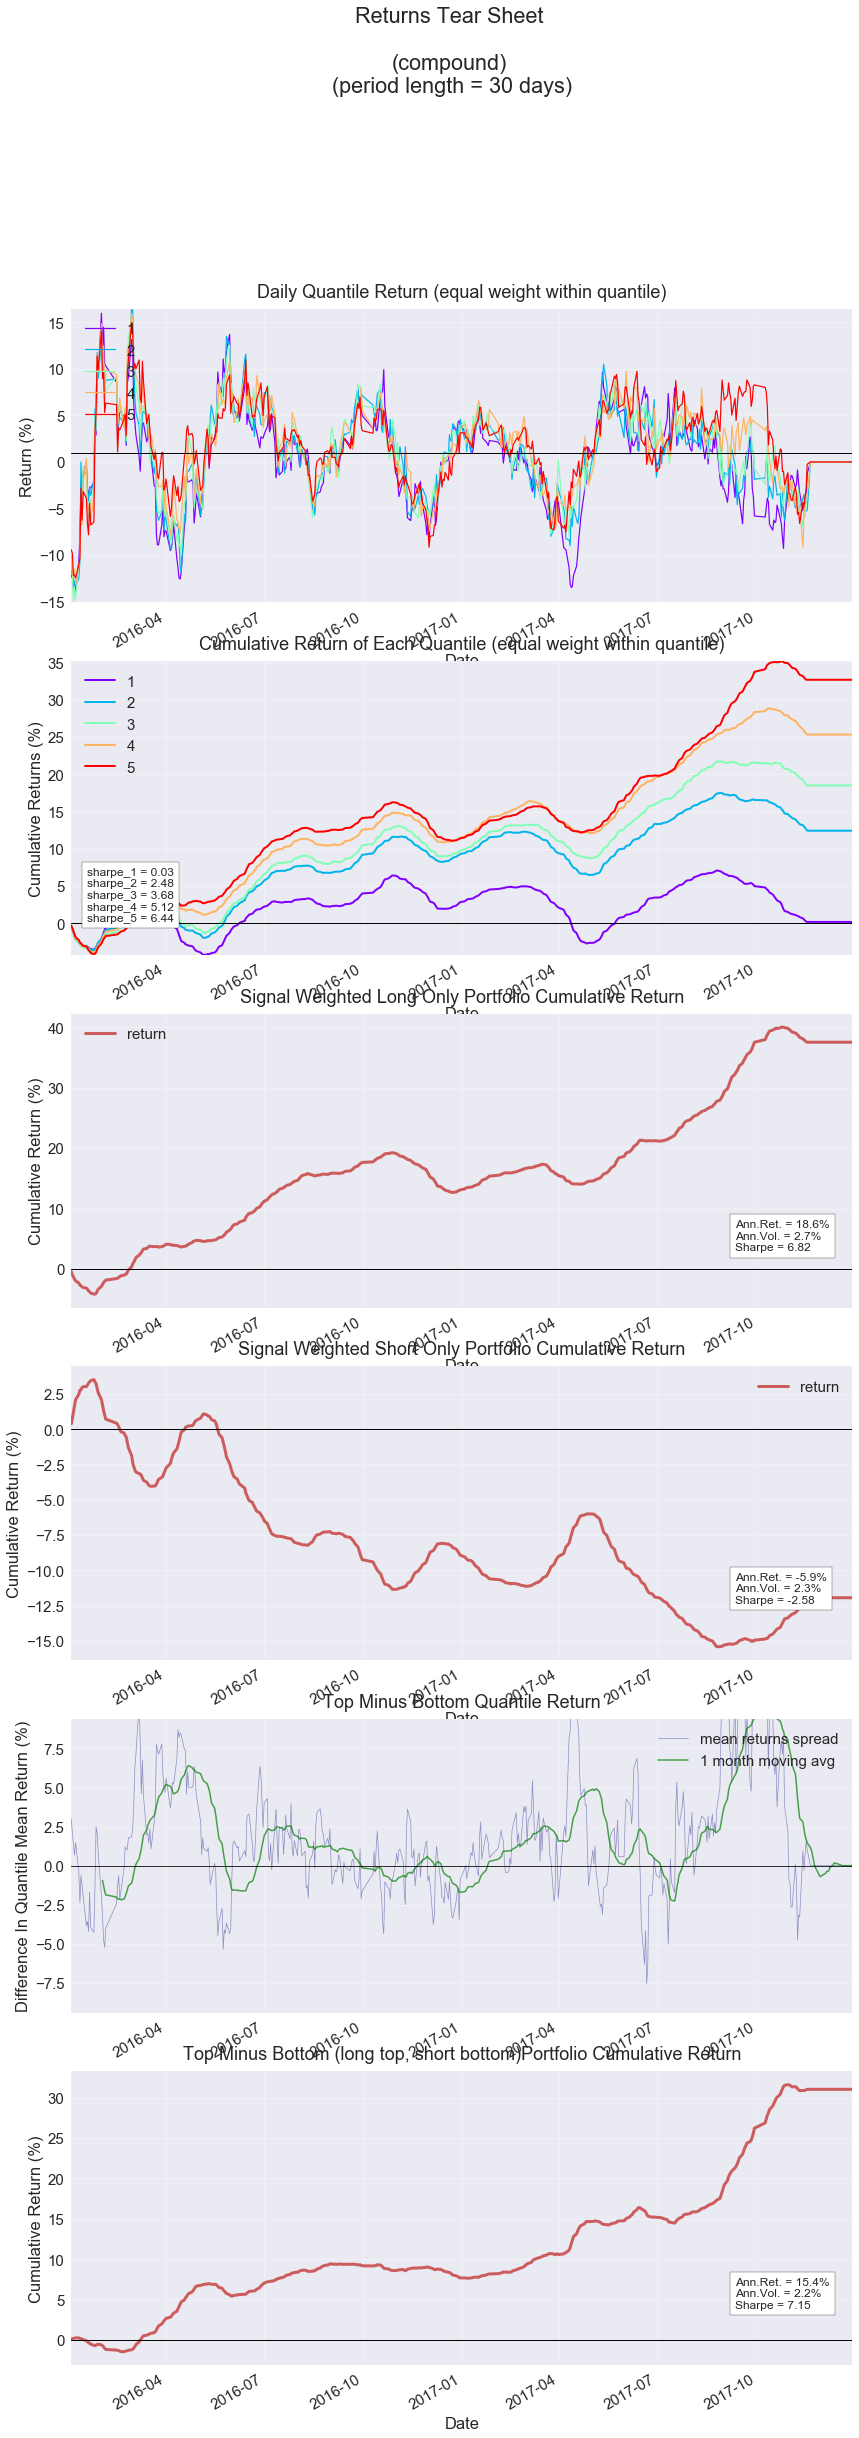

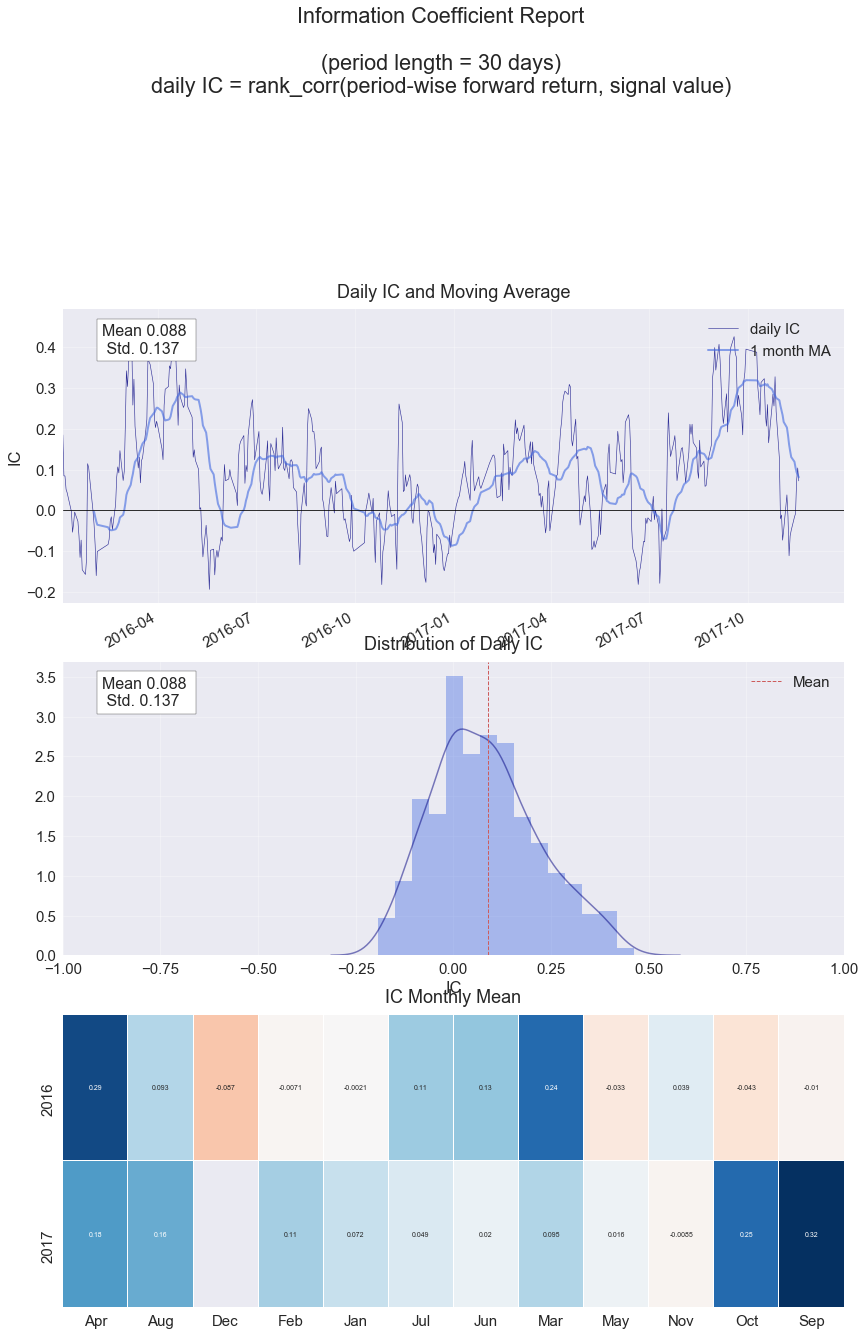

In [23]:
draw_analysis(optimizer.all_signals[ret_best[0]["signal_name"]].loc[20160101:], period=30)

In [24]:
# 以持有期mean_ic为最优化目标
ic_best = optimizer.enumerate_optimizer(target_type="return_ic",#优化目标类型
                                        target = "IC Mean",
                                        in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                        ascending=False)

In [25]:
print(ic_best[0]["signal_name"])
print(ic_best[0]["ic"])
print(ic_best[0]["ret"])
print(ic_best[0]["space"])

divert{'LEN': 12}
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean      4.977689e-02       0.007567     4.067761e-02
IC Std.      1.375455e-01       0.136779     1.309188e-01
t-stat(IC)   7.994500e+00       1.222116     6.863780e+00
p-value(IC)  9.526921e-15       0.222255     2.048308e-11
IC Skew     -2.788311e-01      -0.168869     1.339354e-01
IC Kurtosis  3.586011e-01       0.880461     3.290019e-01
Ann. IR      3.618940e-01       0.055323     3.107087e-01
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       5.124623   -4.671154        3.002314         33.406886   
p-value      0.000000    0.000000        0.002820          0.000000   
skewness    -0.574749    0.308295       -1.134718          0.672716   
kurtosis    -0.020546   -0.321323        4.024431          3.701657   
Ann. Ret     0.263163   -0.254330        0.026169          0.309079   
Ann. Vol     0.399007    0.423049        0.067725          0.534581   
Ann. IR      0.659545

In [26]:
excel_data = optimizer.all_signals[ret_best[0]["signal_name"]][optimizer.all_signals[ret_best[0]["signal_name"]]['quantile']==5]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
print (excel_data.head())
excel_data.to_excel('./divert_opt_quantile_5.xlsx')

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000024.SZ  \
trade_date                                                                     
20140103          1.0        0.0        0.0        0.0        0.0        1.0   
20140106          0.0        0.0        0.0        0.0        0.0        1.0   
20140107          0.0        1.0        0.0        0.0        1.0        1.0   
20140108          0.0        1.0        0.0        0.0        1.0        1.0   
20140109          0.0        0.0        0.0        0.0        0.0        1.0   

symbol      000027.SZ  000039.SZ  000046.SZ  000060.SZ    ...      601997.SH  \
trade_date                                                ...                  
20140103          0.0        0.0        1.0        0.0    ...            0.0   
20140106          0.0        0.0        1.0        0.0    ...            0.0   
20140107          0.0        0.0        1.0        0.0    ...            0.0   
20140108          0.0        0.0       

## 2. 事件参数优化

In [27]:
event_opt = Optimizer(dataview=dv,
                      formula="(Ts_Mean(close_adj, SHORT)>=Ts_Mean(close_adj, LONG))&&(Delay(Ts_Mean(close_adj, SHORT)<Ts_Mean(close_adj, LONG), 1))",
                      params={'SHORT':range(5,11,1),'LONG':range(30,61,5)},
                      name='cross',
                      price=price,
                      high=high,
                      low=low,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=30,
                      n_quantiles=1,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=True,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

In [28]:
event_best = event_opt.enumerate_optimizer(target_type="long_ret",
                                           target="Ann. IR",
                                           in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                           ascending=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 56%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective da

In [29]:
# 事件样本内最优绩效 ps：事件没有ic分析结果
# 可以进一步尝试优化space，辅以更精细的择时捕捉事件收益
print(event_best[0]["signal_name"])
print(event_best[0]["ret"])
print(event_best[0]["space"])

cross{'SHORT': 10, 'LONG': 55}
              long_ret  long_short_ret  all_sample_ret
t-stat       12.313107       -2.266010       69.719295
p-value       0.000000        0.024080        0.000000
skewness      1.005597        0.408082        0.930253
kurtosis      4.215330        2.882389        4.189708
Ann. Ret      0.453946       -0.047620        0.311239
Ann. Vol      0.495812        0.135829        0.569307
Ann. IR       0.915561       -0.350585        0.546699
occurance  1460.000000      338.000000   131192.000000
                long_space  all_sample_space
Up_sp Mean        0.165475          0.169426
Up_sp Std         0.165639          0.173804
Up_sp IR          0.999012          0.974813
Up_sp Pct5        0.004537          0.006992
Up_sp Pct25       0.049488          0.052771
Up_sp Pct50       0.118248          0.120406
Up_sp Pct75       0.234487          0.229496
Up_sp Pct95       0.475575          0.496821
Up_sp Occur    1460.000000     131192.000000
Down_sp Mean     -0.1454

#### 可视化



Value of signals of Different Quantiles Statistics
          min  max     mean       std   count  count %
quantile                                              
1         0.0  1.0  0.01183  0.108122  269647    100.0
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.005
IC Std.      0.066
t-stat(IC)  -1.849
p-value(IC)  0.065
IC Skew     -0.135
IC Kurtosis  0.011
Ann. IR     -0.070
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


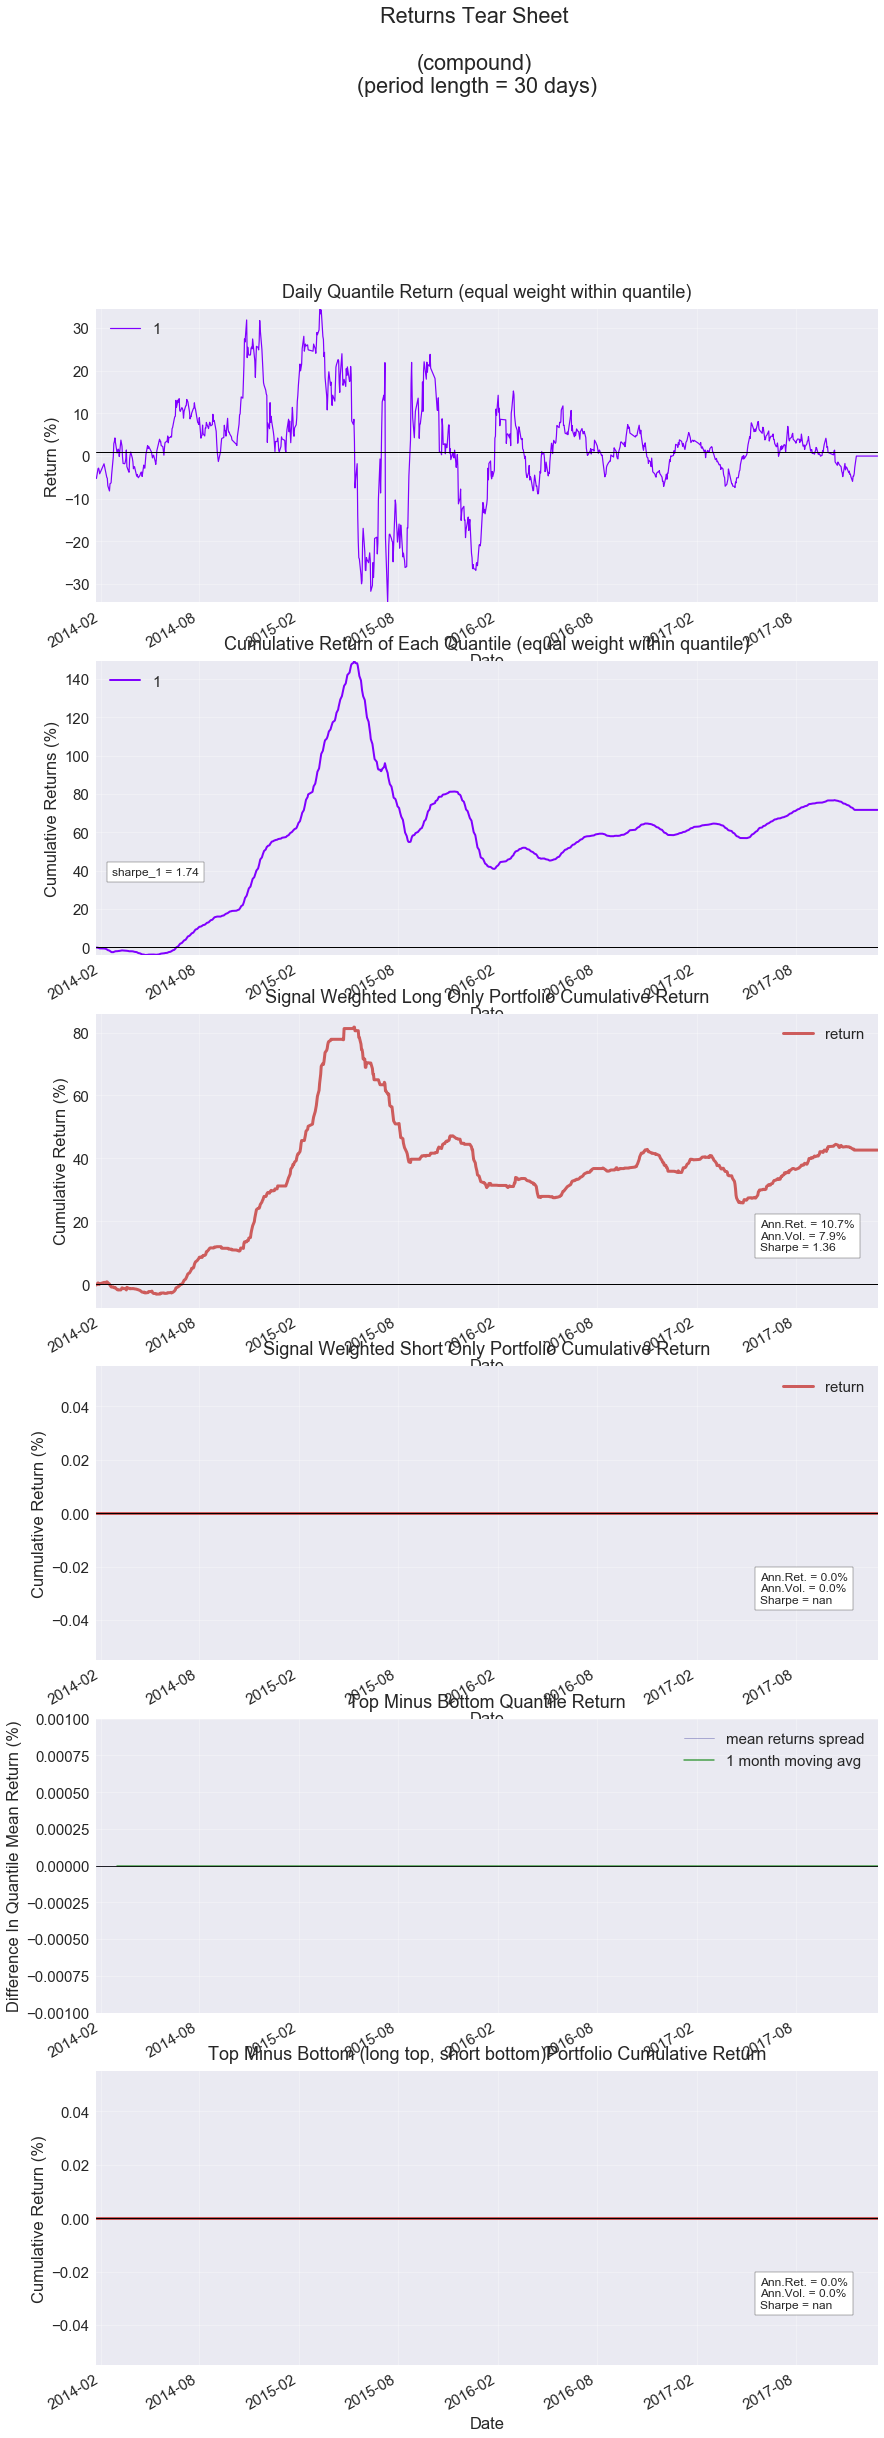

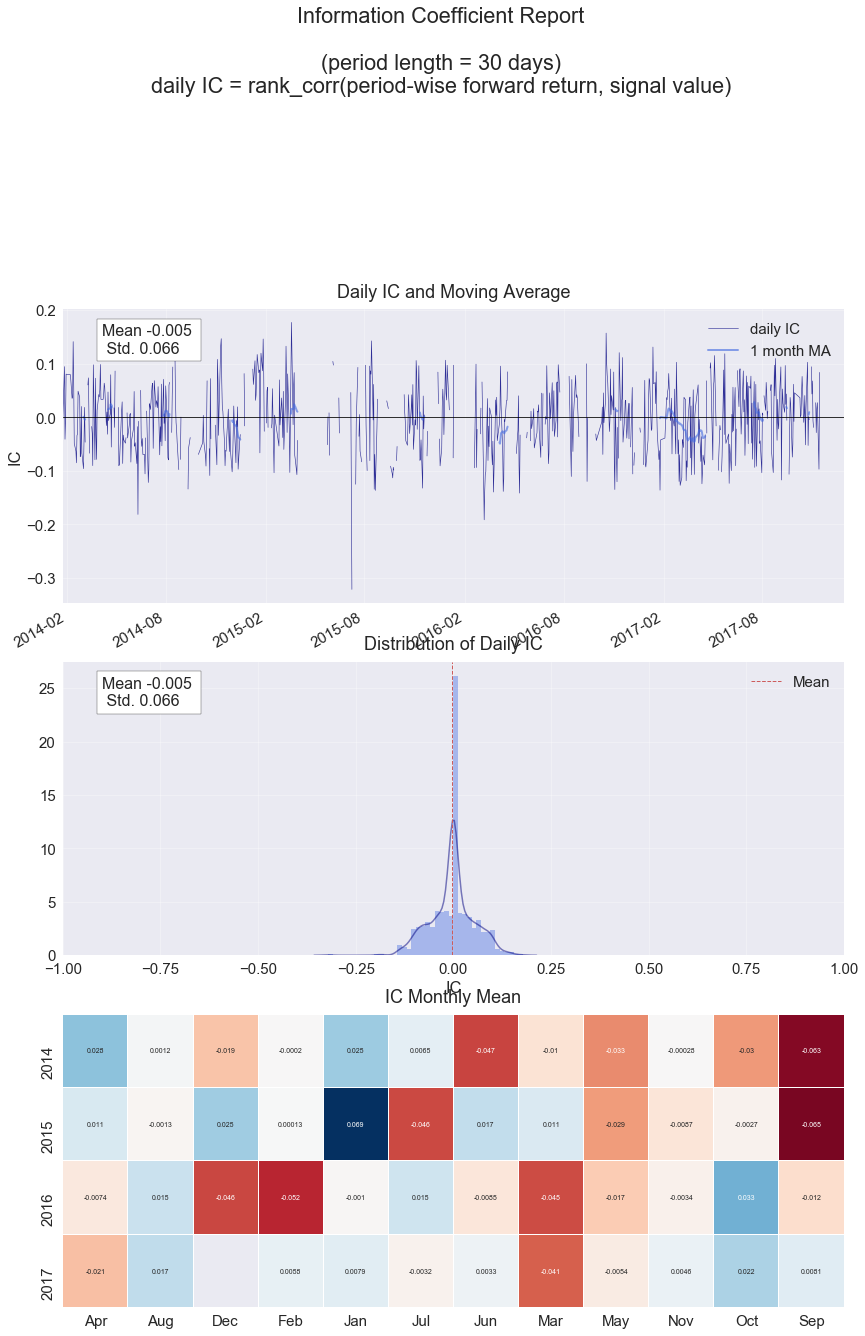

In [30]:
# 全样本
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]], period=30)



Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.011129  0.104905  131192    100.0
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.004
IC Std.      0.068
t-stat(IC)  -1.202
p-value(IC)  0.230
IC Skew     -0.118
IC Kurtosis  0.520
Ann. IR     -0.065
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


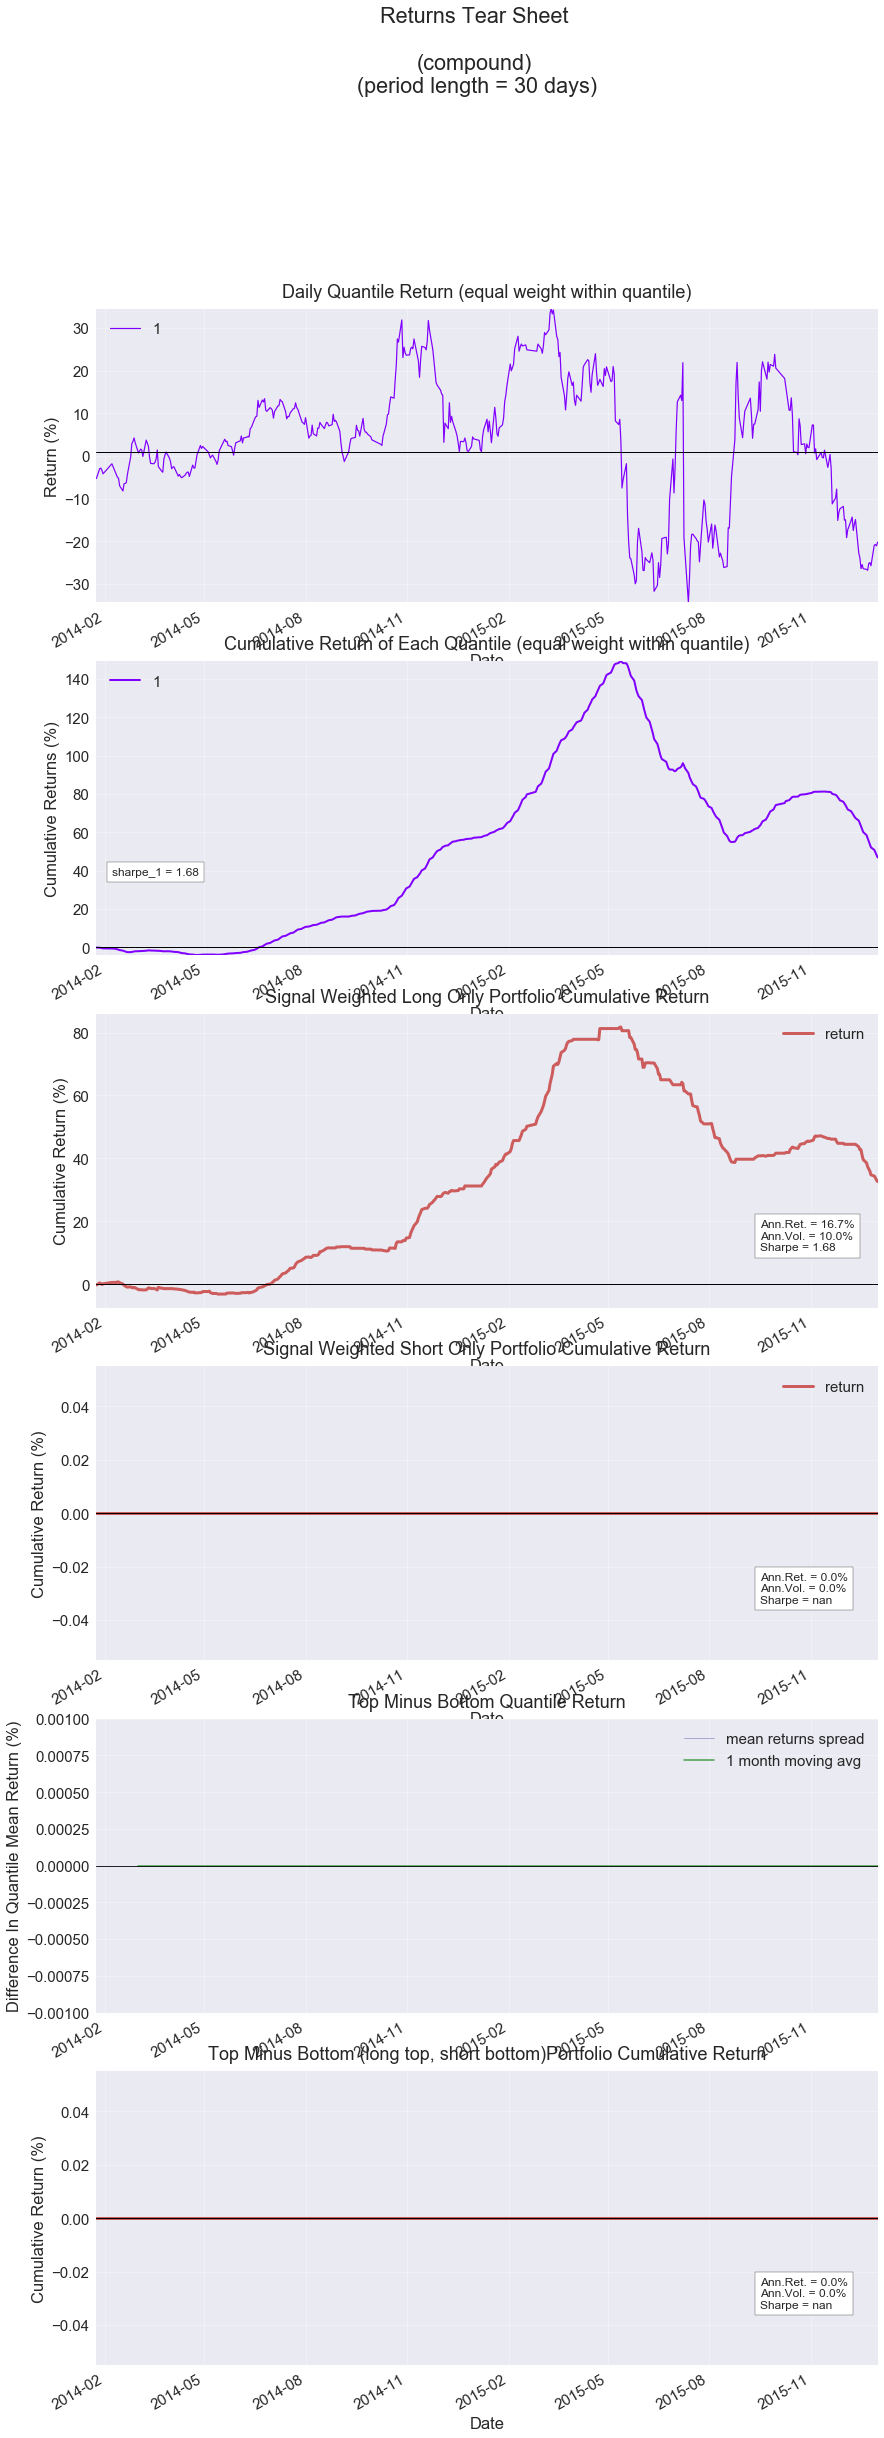

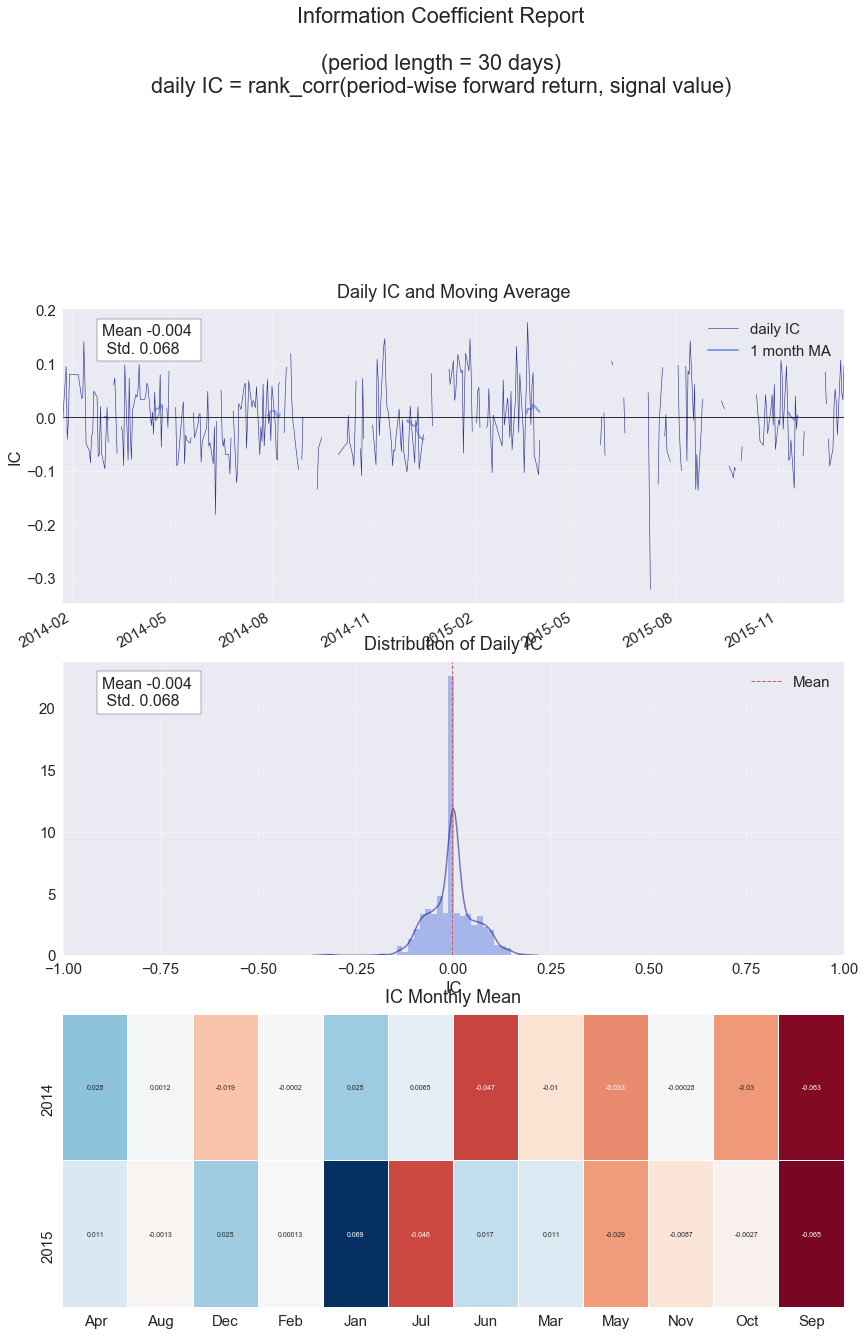

In [31]:
# 样本内
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]].loc[20140101:20160101], period=30)



Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.012495  0.111081  138455    100.0
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\returns_report.pdf
Information Analysis
                ic
IC Mean     -0.005
IC Std.      0.064
t-stat(IC)  -1.413
p-value(IC)  0.158
IC Skew     -0.154
IC Kurtosis -0.623
Ann. IR     -0.074
Figure saved: E:\2018_Course\HighSchool\Final\5_因子研发工具实操Richard\information_report.pdf


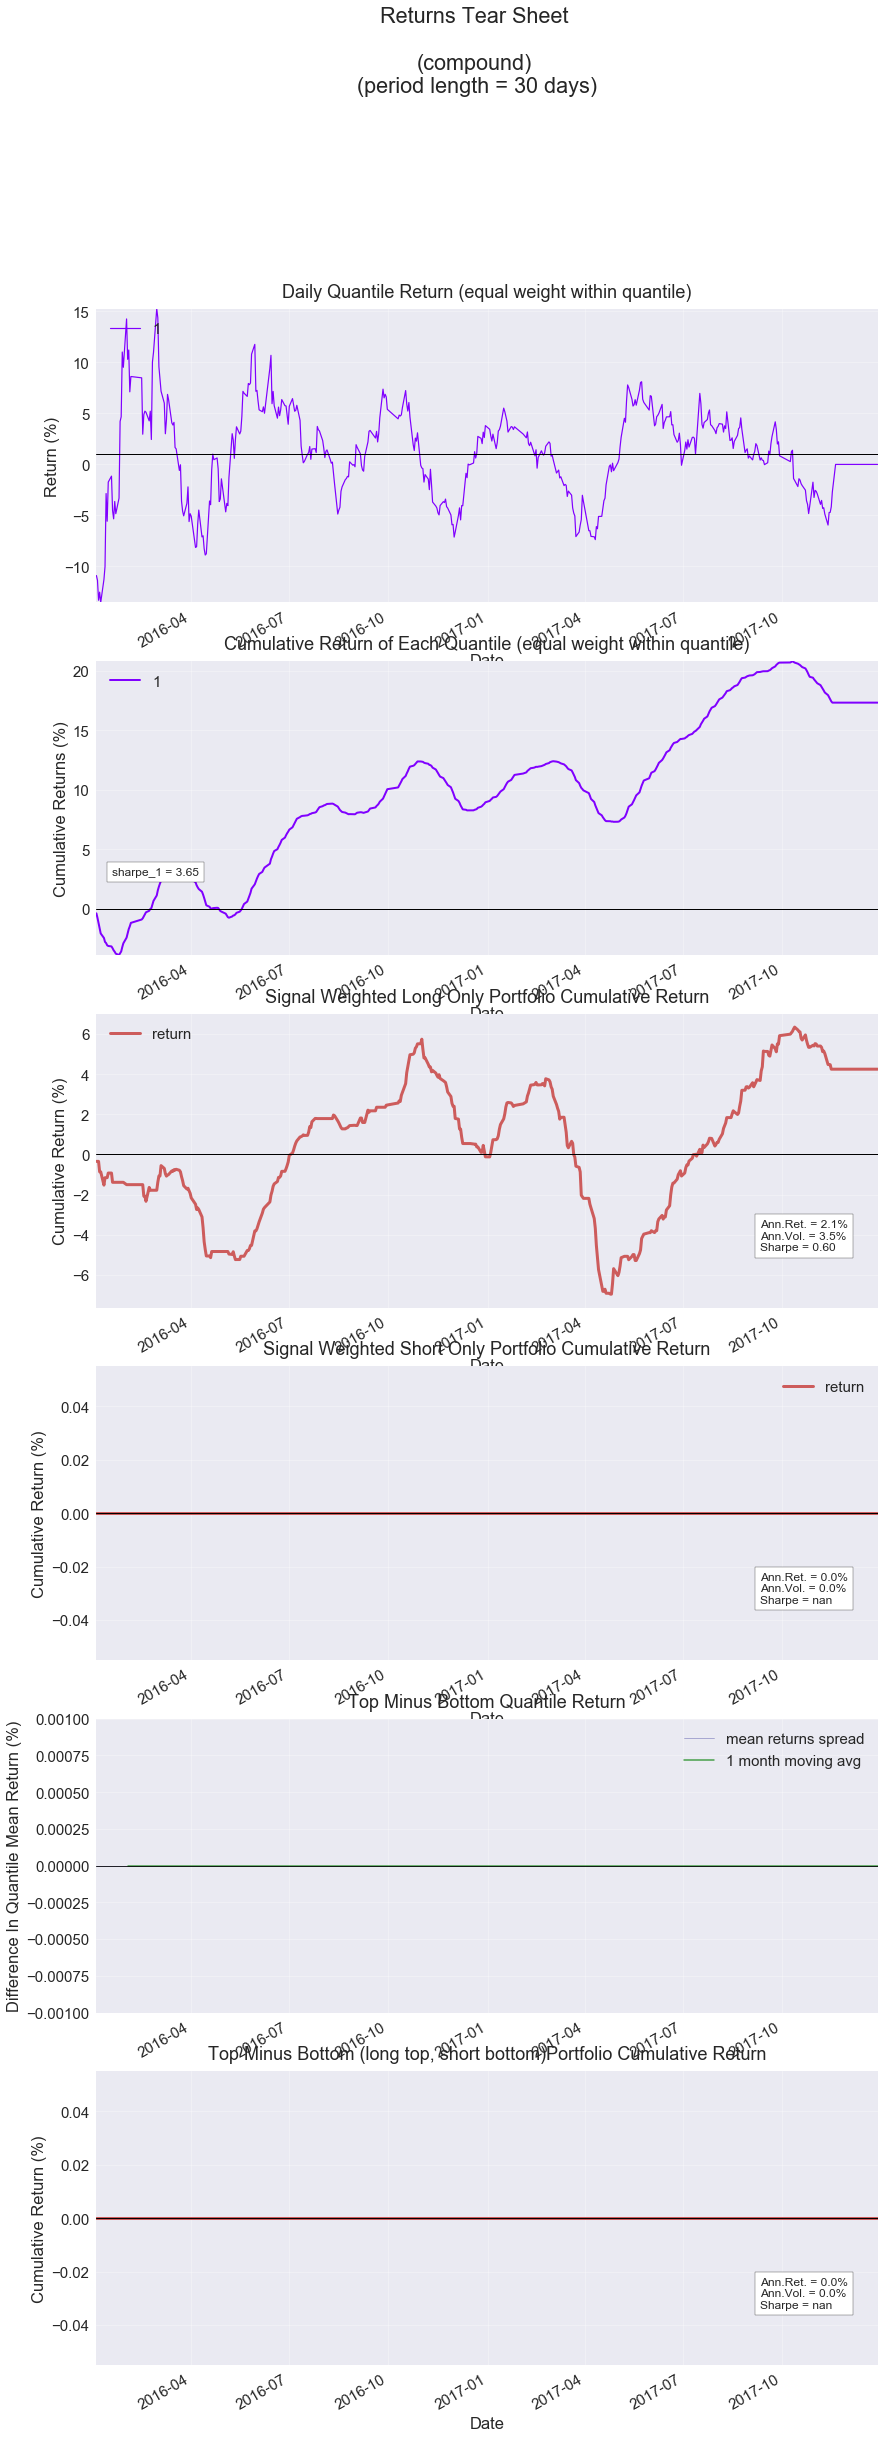

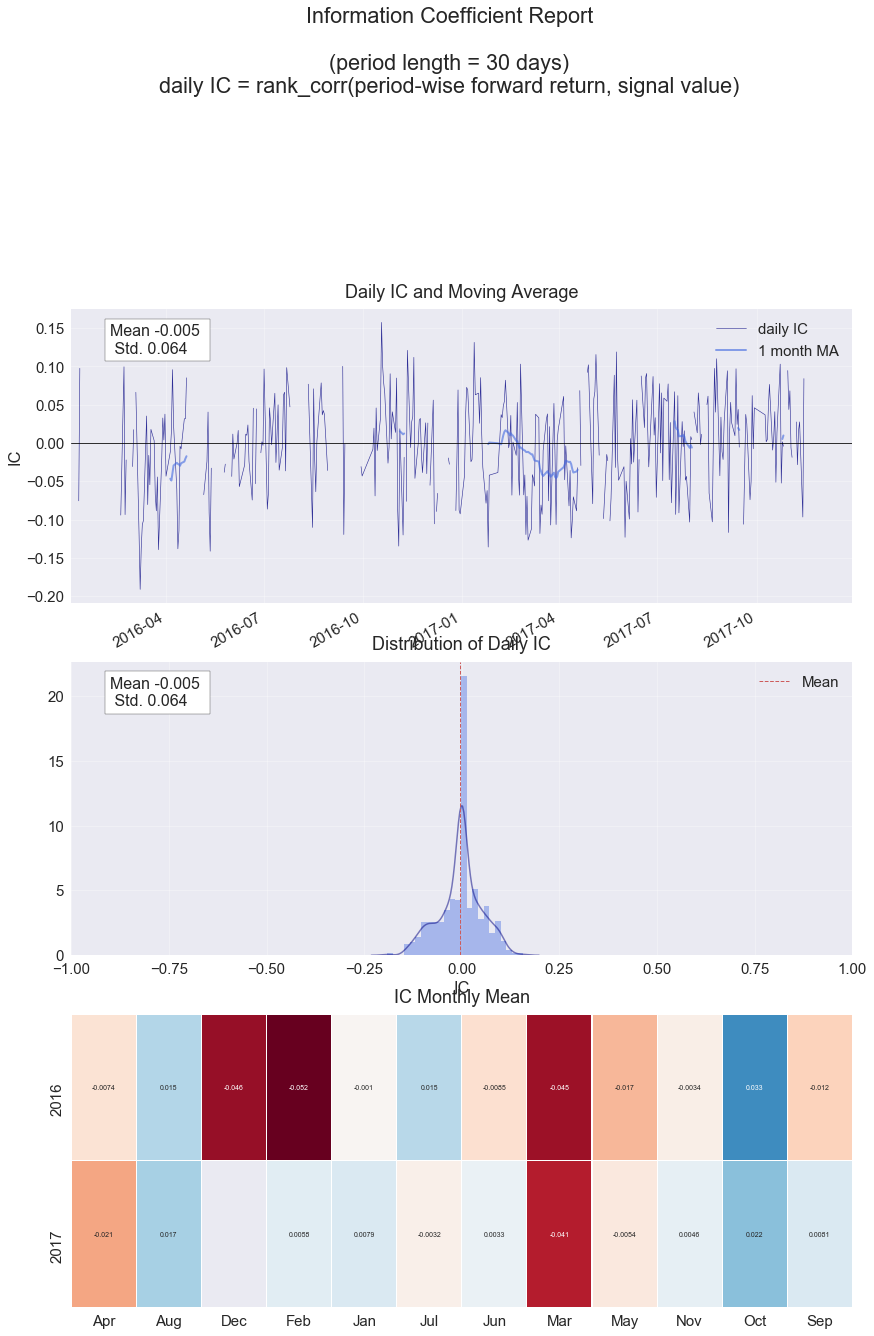

In [32]:
# 样本外
draw_analysis(event_opt.all_signals[event_best[0]["signal_name"]].loc[20160101:], period=30)

## 3. 拓展：外部自定义带参算法优化

In [33]:
import pandas as pd
import talib as ta

slp_opt =   Optimizer(dataview=dv,
                      price=price,
                      period=30,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

signals_dict = {}
for param in range(2,9,1):
    slope_df = pd.DataFrame({name: -ta.LINEARREG_SLOPE(value.values, param) for name, value in price.iteritems()}, index=price.index)
    dv.append_df(slope_df,'SLOPE_PARAM='+str(param))
    signals_dict['SLOPE_PARAM='+str(param)] = slp_opt.cal_signal(dv.get_ts('SLOPE_PARAM='+str(param)))

Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 57%


In [34]:
slp_opt.all_signals = signals_dict

In [35]:
# 以持有期mean_ic为最优化目标
slp_best = slp_opt.enumerate_optimizer(target_type="return_ic",#优化目标类型
                                       target = "IC Mean",
                                       in_sample_range=[20140101,20160101],#样本内范围 默认为None,在全样本上优化
                                       ascending=False)

In [36]:
# 样本内绩效
print(slp_best[0]["signal_name"])
print(slp_best[0]["ic"])
print(slp_best[0]["ret"])

SLOPE_PARAM=8
                return_ic  upside_ret_ic  downside_ret_ic
IC Mean      4.310682e-02       0.013728     5.593689e-02
IC Std.      1.622111e-01       0.161274     1.560077e-01
t-stat(IC)   5.828245e+00       1.866859     7.863662e+00
p-value(IC)  1.028626e-08       0.062531     2.483445e-14
IC Skew      4.934076e-02       0.214033     1.260678e-01
IC Kurtosis  1.926748e-01       0.320293     3.347468e-02
Ann. IR      2.657451e-01       0.085121     3.585521e-01
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       3.819739   -1.736368        4.529189         32.491975   
p-value      0.000150    0.083140        0.000010          0.000000   
skewness    -0.249597    0.317080        0.363507          0.935224   
kurtosis    -0.148464   -0.301540        1.743548          4.261522   
Ann. Ret     0.210201   -0.096996        0.052268          0.314857   
Ann. Vol     0.424498    0.430009        0.089020          0.555765   
Ann. IR      0.495177   -